## Setup

In [38]:
!pip uninstall -y backports.zoneinfo backports
!pip install --upgrade setuptools
!pip install fiftyone torch torchvision numpy matplotlib tqdm


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
import os
import random
from pathlib import Path
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
import fiftyone as fo
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"


## Load Curated Datasets

Assuming you've already created curated datasets with 'curated_label' field containing IDK labels.

In [40]:
import fiftyone.zoo as foz
import fiftyone.utils.random as four
import os

# Load the curated datasets
try:
    train_dataset = fo.load_dataset("mnist-training-set")
    val_dataset = fo.load_dataset("mnist-validation-set")
    print("Loaded existing datasets.")
except fo.DatasetNotFoundError:
    print("Datasets not found in FiftyOne DB. Creating them from scratch.")
    
    # Clean up temp dataset if exists
    if "mnist-train-val-temp" in fo.list_datasets():
        fo.delete_dataset("mnist-train-val-temp")

    # Load and split MNIST
    train_val_dataset = foz.load_zoo_dataset("mnist", split="train", dataset_name="mnist-train-val-temp")
    
    # 85/15 Split
    four.random_split(train_val_dataset, {"train": 0.85, "validation": 0.15}, seed=51)
    
    # Create distinct datasets
    train_dataset = train_val_dataset.match_tags("train").clone()
    train_dataset.name = "mnist-training-set"
    train_dataset.persistent = True
    
    val_dataset = train_val_dataset.match_tags("validation").clone()
    val_dataset.name = "mnist-validation-set"
    val_dataset.persistent = True
    
    # Set default labels
    for sample in train_dataset:
        sample["curated_label"] = sample["ground_truth"]
        sample.save()
        
    for sample in val_dataset:
        sample["curated_label"] = sample["ground_truth"]
        sample.save()
        
    fo.delete_dataset("mnist-train-val-temp")
    print("Created new datasets 'mnist-training-set' and 'mnist-validation-set'.")

# ---------------------------------------------------------
# RELOAD IDK LABELS: Force apply the IDK labels to ensure they exist
# ---------------------------------------------------------
print("\nRe-applying IDK labels to ensure they are present...")
idk_filenames_train = {
    "032739.jpg", "048934.jpg", "025547.jpg", "045918.jpg", "031302.jpg", "022131.jpg",
    "048882.jpg", "035063.jpg", "021991.jpg", "034522.jpg", "019869.jpg", "049684.jpg",
    "037428.jpg", "026851.jpg", "026835.jpg", "048976.jpg", "010206.jpg", "053737.jpg",
    "042688.jpg", "056398.jpg", "032245.jpg", "054783.jpg", "021602.jpg", "017740.jpg",
    "005014.jpg", "036349.jpg", "032574.jpg", "016677.jpg", "013260.jpg", "057883.jpg",
    "006756.jpg", "011658.jpg", "012615.jpg", "059654.jpg", "041425.jpg", "054343.jpg",
    "025955.jpg", "045267.jpg", "052915.jpg", "014791.jpg", "023465.jpg", "021383.jpg",
    "005085.jpg", "009456.jpg", "036767.jpg"
}

def set_curated_labels_force(dataset, idk_filenames):
    count = 0
    updates = 0
    for sample in dataset:
        basename = os.path.basename(sample.filepath)
        if basename in idk_filenames:
            if sample["curated_label"].label != "IDK":
                sample["curated_label"] = fo.Classification(label="IDK")
                sample.save()
                updates += 1
            count += 1
    print(f"  Dataset {dataset.name}: Found {count} IDK samples (Updated {updates})")

set_curated_labels_force(train_dataset, idk_filenames_train)
set_curated_labels_force(val_dataset, idk_filenames_train)

print(f"\nTrain dataset: {len(train_dataset)} samples")
print(f"Val dataset: {len(val_dataset)} samples")

# Show class distribution
curated_classes = sorted(train_dataset.distinct("curated_label.label"))
print(f"\nCurated classes: {curated_classes}")

for cls in curated_classes:
    count = len(train_dataset.match(fo.ViewField("curated_label.label") == cls))
    print(f"  {cls}: {count} samples")

Loaded existing datasets.

Re-applying IDK labels to ensure they are present...
  Dataset mnist-training-set: Found 45 IDK samples (Updated 45)
  Dataset mnist-validation-set: Found 4 IDK samples (Updated 4)

Train dataset: 60000 samples
Val dataset: 9000 samples

Curated classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine', 'IDK']
  0 - zero: 5917 samples
  1 - one: 6736 samples
  2 - two: 5949 samples
  3 - three: 6128 samples
  4 - four: 5841 samples
  5 - five: 5413 samples
  6 - six: 5916 samples
  7 - seven: 6264 samples
  8 - eight: 5848 samples
  9 - nine: 5943 samples
  IDK: 45 samples


## Define LeNet5 Model

In [41]:
class ClassicLeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(ClassicLeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = self.pool1(x)
        x = torch.tanh(self.conv2(x))
        x = self.pool2(x)
        x = torch.tanh(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

## Create Custom Dataset with IDK Augmentation

In [50]:
class CustomTorchImageDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        fiftyone_dataset,
        base_transforms=None,
        idk_transforms=None,
        label_map=None,
        gt_field="ground_truth",
        idk_label_str="IDK",
    ):
        """
        Args:
            fiftyone_dataset: The FiftyOne dataset/view to load from
            base_transforms: Transforms to apply to all images
            idk_transforms: Additional transforms for IDK class only
            label_map: Dict mapping string labels to integer indices
            gt_field: Field name containing the labels (e.g. 'curated_label')
            idk_label_str: String label that represents the IDK class
        """
        # Note: We do NOT store self.fiftyone_dataset because it contains MongoDB connections
        # which cannot be pickled for multiprocessing (num_workers > 0) on Windows.
        # Instead, we immediately extract the list of filepaths and labels.
        self.image_paths = fiftyone_dataset.values("filepath")
        self.str_labels = fiftyone_dataset.values(f"{gt_field}.label")
        
        self.base_transforms = base_transforms
        self.idk_transforms = idk_transforms
        self.idk_label_str = idk_label_str
        self.label_map = label_map

        print(
            f"CustomTorchImageDataset initialized with {len(self.image_paths)} samples "
            f"(gt_field='{gt_field}', idk_label='{self.idk_label_str}')."
        )
        
        # Validate that we have labels for all images
        if not self.str_labels or len(self.str_labels) != len(self.image_paths):
            print("WARNING: Number of labels doesn't match number of images!")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        try:
            image = Image.open(image_path).convert("L")
        except Exception as e:
            print(f"Error loading {image_path}: {e}")
            # Return dummy data to avoid crashing
            return torch.zeros(1, 28, 28), torch.tensor(0, dtype=torch.long)
            
        label_str = self.str_labels[idx]

        # Apply base transforms to all samples
        if self.base_transforms is not None:
            image = self.base_transforms(image)

        # Apply additional transforms only for IDK samples
        if (self.idk_transforms is not None) and (label_str == self.idk_label_str):
            image = self.idk_transforms(image)

        # Get label index
        if self.label_map:
            label_idx = self.label_map.get(label_str, -1)
            if label_idx == -1:
                # Fallback or error handling
                # print(f"Warning: Unknown label '{label_str}'")
                label_idx = 0 
        else:
            # Try to convert directly if no map provided
            try:
                label_idx = int(label_str)
            except:
                label_idx = 0
                
        return image, torch.tensor(label_idx, dtype=torch.long)

## Setup Data Transforms and Label Mapping

In [51]:
# Compute normalization stats (or use pre-computed values)
# For MNIST, typical values are:
mean_intensity = 0.1307  # You can recompute if needed
std_intensity = 0.3081

# Base transforms for all images
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean_intensity,), (std_intensity,))
])

# IDK-specific augmentation (to enrich the small IDK class)
mnist_augmentations_idk = transforms.Compose([
    transforms.RandomApply(
        [
            transforms.GaussianBlur(3),
            transforms.RandomAffine(
                degrees=15,
                translate=(0.1, 0.1),
                scale=(0.9, 1.1),
                shear=10,
            ),
        ],
        p=0.95,
    ),
])

# Create label map (0-9 for digits, 10 for IDK)
curated_classes = sorted(train_dataset.distinct("curated_label.label"))
digit_labels = sorted([c for c in curated_classes if c != "IDK"])
idk_label_map = {lbl: idx for idx, lbl in enumerate(digit_labels)}
idk_label_map["IDK"] = len(digit_labels)

print("Label map:", idk_label_map)

Label map: {'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9, 'IDK': 10}


## Create Torch Datasets and DataLoaders

In [58]:
# Create torch datasets
idk_torch_train = CustomTorchImageDataset(
    fiftyone_dataset=train_dataset,
    base_transforms=image_transforms,
    idk_transforms=mnist_augmentations_idk,
    label_map=idk_label_map,
    gt_field="curated_label",
    idk_label_str="IDK",
)

idk_torch_val = CustomTorchImageDataset(
    fiftyone_dataset=val_dataset,
    base_transforms=image_transforms,
    idk_transforms=None,  # No augmentation for validation
    label_map=idk_label_map,
    gt_field="curated_label",
)

print(f"\nTrain dataset: {len(idk_torch_train)} samples")
print(f"Val dataset: {len(idk_torch_val)} samples")

CustomTorchImageDataset initialized with 60000 samples (gt_field='curated_label', idk_label='IDK').
CustomTorchImageDataset initialized with 9000 samples (gt_field='curated_label', idk_label='IDK').

Train dataset: 60000 samples
Val dataset: 9000 samples


In [ ]:
# Create weighted sampler to balance IDK class
labels = [idk_label_map[lbl] for lbl in idk_torch_train.str_labels]
unique_labels, counts = np.unique(labels, return_counts=True)
count_map = dict(zip(unique_labels, counts))
idk_idx = idk_label_map["IDK"]

print("Class distribution:")
for label_idx, count in count_map.items():
    label_name = [k for k, v in idk_label_map.items() if v == label_idx][0]
    print(f"  {label_name} (idx={label_idx}): {count} samples")

# 1. Base Strategy: Inverse Frequency (balances the classes so each appears equally)
weights_per_class = {c: 1.0 / count for c, count in count_map.items()}

# 2. Boost Strategy: Force 'IDK' to appear more frequently than other classes
#    Standard balanced sampling makes each class ~1/11th of the batch (~9%).
#    Boosting IDK weight allows us to "oversample" it even further.
IDK_BOOST_FACTOR = 2.0  
weights_per_class[idk_idx] *= IDK_BOOST_FACTOR

print(f"\nWeights per class (IDK Boost = {IDK_BOOST_FACTOR}):")
for label_idx, w in weights_per_class.items():
    label_name = [k for k, v in idk_label_map.items() if v == label_idx][0]
    if label_idx == idk_idx:
        print(f"  -> {label_name}: {w:.6f} (BOOSTED)")
    else:
        print(f"  {label_name}: {w:.6f}")

sample_weights = [weights_per_class[lbl] for lbl in labels]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True,
)

Class distribution:
  0 - zero (idx=0): 5917 samples
  1 - one (idx=1): 6736 samples
  2 - two (idx=2): 5949 samples
  3 - three (idx=3): 6128 samples
  4 - four (idx=4): 5841 samples
  5 - five (idx=5): 5413 samples
  6 - six (idx=6): 5916 samples
  7 - seven (idx=7): 6264 samples
  8 - eight (idx=8): 5848 samples
  9 - nine (idx=9): 5943 samples
  IDK (idx=10): 45 samples

Weights per class (IDK Boost = 2.0):
  0 - zero: 0.000169
  1 - one: 0.000148
  2 - two: 0.000168
  3 - three: 0.000163
  4 - four: 0.000171
  5 - five: 0.000185
  6 - six: 0.000169
  7 - seven: 0.000160
  8 - eight: 0.000171
  9 - nine: 0.000168
  -> IDK: 0.044444 (BOOSTED)


In [61]:
# Create data loaders
batch_size = 64
# Windows + FiftyOne objects cannot be pickled easily for multiprocessing
# Setting num_workers=0 forces data loading in the main process, avoiding the PicklingError
num_workers = 0 

idk_train_loader = DataLoader(
    idk_torch_train,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=True,
    sampler=sampler,
    shuffle=False,  # Don't shuffle when using sampler
)

idk_val_loader = DataLoader(
    idk_torch_val,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)

print(f"\nTrain batches: {len(idk_train_loader)}")
print(f"Val batches: {len(idk_val_loader)}")


Train batches: 938
Val batches: 141


## Define Training Functions

In [62]:
def train_epoch(model, train_loader, optimizer, criterion):
    batch_losses = []
    model.train()

    for images, labels in tqdm(train_loader, desc="Training"):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss_value = criterion(logits, labels)

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        batch_losses.append(loss_value.item())

    return np.mean(batch_losses)


def val_epoch(model, val_loader, criterion, return_accuracy=False):
    batch_losses = []
    correct = 0
    total = 0

    model.eval()
    with torch.inference_mode():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            loss_value = criterion(logits, labels)
            batch_losses.append(loss_value.item())

            if return_accuracy:
                _, preds = torch.max(logits, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

    val_loss = np.mean(batch_losses)

    if return_accuracy:
        return val_loss, correct / total

    return val_loss

## Train IDK Model (11 Classes)

In [63]:
# Initialize model
idk_model = ClassicLeNet5(num_classes=11).to(device)

# Setup training
criterion = nn.CrossEntropyLoss()
optimizer = Adam(
    idk_model.parameters(),
    lr=0.003,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0
)

n_epochs = 10
train_losses = []
val_losses = []
val_accuracies = []
best_val_loss = float("inf")
idk_checkpoint_path = Path("best_lenet_idk.pth")

print(f"\n{'='*60}")
print("Starting IDK Model Training (11 classes)")
print(f"{'='*60}\n")


Starting IDK Model Training (11 classes)



In [64]:
# Training loop
for epoch in range(n_epochs):
    train_loss = train_epoch(idk_model, idk_train_loader, optimizer, criterion)
    val_loss, val_acc = val_epoch(idk_model, idk_val_loader, criterion, return_accuracy=True)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{n_epochs} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(idk_model.state_dict(), idk_checkpoint_path)
        print(f" -> Saved improved model to {idk_checkpoint_path}")

print(f"\n{'='*60}")
print(f"Training Complete!")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Best validation accuracy: {max(val_accuracies):.4f}")
print(f"Model saved to: {idk_checkpoint_path}")
print(f"{'='*60}")

Validation: 100%|██████████| 141/141 [00:16<00:00,  8.44it/s]


Epoch 1/10 | Train Loss: 0.2279 | Val Loss: 0.1094 | Val Acc: 0.9663
 -> Saved improved model to best_lenet_idk.pth


Validation: 100%|██████████| 141/141 [00:03<00:00, 38.91it/s]


Epoch 2/10 | Train Loss: 0.0814 | Val Loss: 0.0706 | Val Acc: 0.9788
 -> Saved improved model to best_lenet_idk.pth


Validation: 100%|██████████| 141/141 [00:03<00:00, 37.91it/s]


Epoch 3/10 | Train Loss: 0.0654 | Val Loss: 0.0551 | Val Acc: 0.9832
 -> Saved improved model to best_lenet_idk.pth


Validation: 100%|██████████| 141/141 [00:03<00:00, 38.14it/s]


Epoch 4/10 | Train Loss: 0.0578 | Val Loss: 0.0546 | Val Acc: 0.9818
 -> Saved improved model to best_lenet_idk.pth


Validation: 100%|██████████| 141/141 [00:03<00:00, 39.15it/s]


Epoch 5/10 | Train Loss: 0.0510 | Val Loss: 0.0468 | Val Acc: 0.9848
 -> Saved improved model to best_lenet_idk.pth


Validation: 100%|██████████| 141/141 [00:03<00:00, 37.21it/s]


Epoch 6/10 | Train Loss: 0.0501 | Val Loss: 0.0524 | Val Acc: 0.9834


Validation: 100%|██████████| 141/141 [00:03<00:00, 38.27it/s]


Epoch 7/10 | Train Loss: 0.0471 | Val Loss: 0.0690 | Val Acc: 0.9772


Validation: 100%|██████████| 141/141 [00:03<00:00, 38.33it/s]


Epoch 8/10 | Train Loss: 0.0445 | Val Loss: 0.0367 | Val Acc: 0.9880
 -> Saved improved model to best_lenet_idk.pth


Validation: 100%|██████████| 141/141 [00:03<00:00, 38.09it/s]


Epoch 9/10 | Train Loss: 0.0466 | Val Loss: 0.0412 | Val Acc: 0.9863


Validation: 100%|██████████| 141/141 [00:03<00:00, 37.86it/s]

Epoch 10/10 | Train Loss: 0.0408 | Val Loss: 0.0416 | Val Acc: 0.9864

Training Complete!
Best validation loss: 0.0367
Best validation accuracy: 0.9880
Model saved to: best_lenet_idk.pth


## Visualize Training Progress

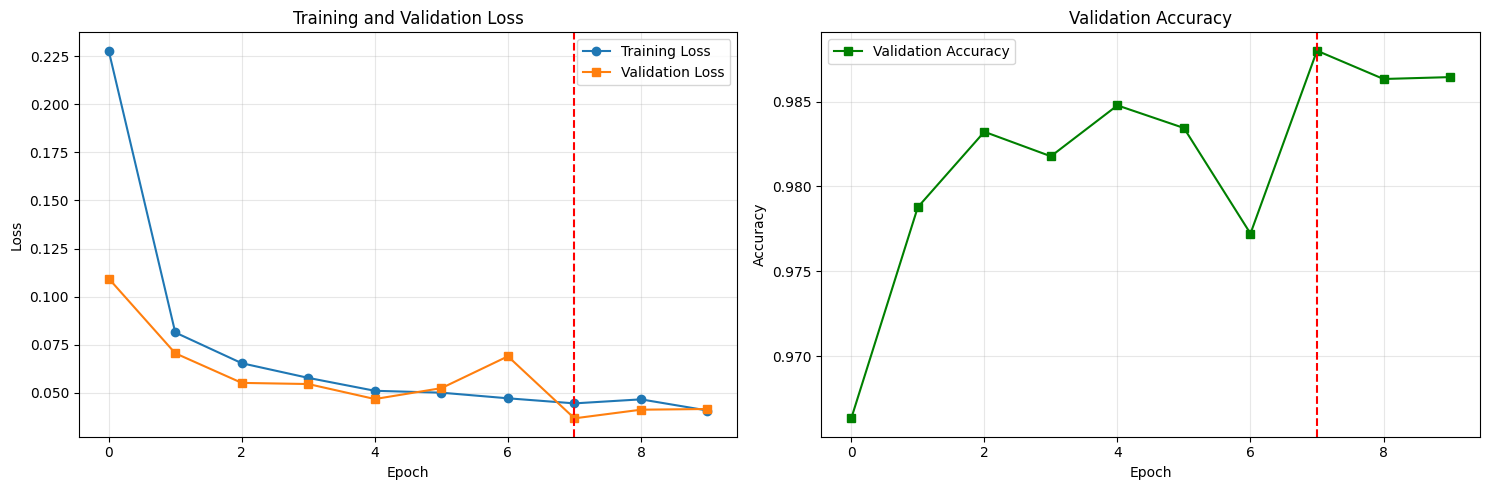


Best epoch: 8
Best val loss: 0.0367
Best val accuracy: 0.9880


In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(train_losses, label='Training Loss', marker='o')
ax1.plot(val_losses, label='Validation Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Find best epoch
best_epoch = np.argmin(val_losses) + 1
ax1.axvline(x=best_epoch-1, color='red', linestyle='--', label=f'Best Epoch {best_epoch}')

# Accuracy plot
ax2.plot(val_accuracies, label='Validation Accuracy', marker='s', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axvline(x=best_epoch-1, color='red', linestyle='--', label=f'Best Epoch {best_epoch}')

plt.tight_layout()
plt.show()

print(f"\nBest epoch: {best_epoch}")
print(f"Best val loss: {min(val_losses):.4f}")
print(f"Best val accuracy: {max(val_accuracies):.4f}")

## Load Best Model for Inference

In [66]:
# Load the best checkpoint
idk_model_best = ClassicLeNet5(num_classes=11)
idk_model_best.load_state_dict(torch.load(idk_checkpoint_path, map_location=device))
idk_model_best = idk_model_best.to(device)
idk_model_best.eval()

print(f"Loaded best IDK model from {idk_checkpoint_path}")
print(f"Model is on device: {next(idk_model_best.parameters()).device}")

Loaded best IDK model from best_lenet_idk.pth
Model is on device: cpu


In [67]:
# ---------------------------------------------------------
# Evaluation: Detailed Performance Analysis
# ---------------------------------------------------------

# Run inference on validation set
idk_model_best.eval()
all_preds = []
all_labels = []

print("Running inference on validation set...")
with torch.inference_mode():
    for images, labels in tqdm(idk_val_loader, desc="Evaluating"):
        images = images.to(device)
        logits = idk_model_best(images)
        preds = torch.argmax(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate confusion matrix manually (to avoid sklearn dependency)
# Rows: Ground Truth, Cols: Predicted
n_classes = 11
idk_index = idk_label_map["IDK"]
confusion = np.zeros((n_classes, n_classes), dtype=int)

for t, p in zip(all_labels, all_preds):
    confusion[t, p] += 1

# ---------------------------------------------------------
# Print Summary Table
# ---------------------------------------------------------
print(f"\n{'='*80}")
print(f"{'Class':<10} | {'Total GT':<10} | {'Correct':<8} | {'Pred as IDK':<12} | {'Accuracy':<8} | {'IDK Rate':<8}")
print(f"{'-'*80}")

total_correct = 0
total_samples = 0

# Sort by index to keep 0-9 then IDK
sorted_map = sorted(idk_label_map.items(), key=lambda x: x[1])

for label_str, class_idx in sorted_map:
    n_samples = np.sum(confusion[class_idx, :])     # Total Ground Truth for this class
    n_correct = confusion[class_idx, class_idx]     # Correct predictions
    n_pred_idk = confusion[class_idx, idk_index]    # How many of this class were called IDK
    
    accuracy = (n_correct / n_samples * 100) if n_samples > 0 else 0.0
    idk_rate = (n_pred_idk / n_samples * 100) if n_samples > 0 else 0.0
    
    # Highlight the IDK row
    prefix = "> " if class_idx == idk_index else "  "
    
    row_str = (f"{prefix}{label_str:<8} | {n_samples:<10} | {n_correct:<8} | "
               f"{n_pred_idk:<12} | {accuracy:6.2f}% | {idk_rate:6.2f}%")
    print(row_str)
    
    total_correct += n_correct
    total_samples += n_samples

print(f"{'-'*80}")
overall_acc = total_correct / total_samples * 100
total_pred_idk = np.sum(confusion[:, idk_index])

print(f"{'OVERALL':<10} | {total_samples:<10} | {total_correct:<8} | "
      f"{total_pred_idk:<12} | {overall_acc:6.2f}% | {'--':<8}")
print(f"{'='*80}")

# ---------------------------------------------------------
# IDK Performance Metrics
# ---------------------------------------------------------
idk_tp = confusion[idk_index, idk_index]            # True Positives (IDK correctly identified)
idk_fp = np.sum(confusion[:, idk_index]) - idk_tp   # False Positives (Normal digits called IDK)
idk_fn = np.sum(confusion[idk_index, :]) - idk_tp   # False Negatives (IDK missed / called digits)

precision = idk_tp / (idk_tp + idk_fp) if (idk_tp + idk_fp) > 0 else 0
recall = idk_tp / (idk_tp + idk_fn) if (idk_tp + idk_fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nIDK Class Deep Dive:")
print(f"  1. Precision: {precision:.2%} (When model says 'IDK', it is correct {precision:.2%} of the time)")
print(f"  2. Recall:    {recall:.2%} (Model found {recall:.2%} of all real IDK samples)")
print(f"  3. F1 Score:  {f1:.4f}")

if idk_fp > 0:
    print(f"\n  Confusion: The model incorrectly labeled {idk_fp} normal digits as 'IDK'.")
else:
    print("\n  Great! The model did not incorrectly label any normal digits as 'IDK'.")

Running inference on validation set...


Evaluating: 100%|██████████| 141/141 [00:03<00:00, 35.39it/s]


Class      | Total GT   | Correct  | Pred as IDK  | Accuracy | IDK Rate
--------------------------------------------------------------------------------
  0 - zero | 917        | 913      | 2            |  99.56% |   0.22%
  1 - one  | 1015       | 1007     | 1            |  99.21% |   0.10%
  2 - two  | 878        | 858      | 2            |  97.72% |   0.23%
  3 - three | 939        | 928      | 0            |  98.83% |   0.00%
  4 - four | 911        | 899      | 1            |  98.68% |   0.11%
  5 - five | 787        | 779      | 0            |  98.98% |   0.00%
  6 - six  | 865        | 858      | 0            |  99.19% |   0.00%
  7 - seven | 896        | 891      | 0            |  99.44% |   0.00%
  8 - eight | 872        | 864      | 1            |  99.08% |   0.11%
  9 - nine | 916        | 891      | 5            |  97.27% |   0.55%
> IDK      | 4          | 4        | 4            | 100.00% | 100.00%
-------------------------------------------------------------------------

## Summary

We've successfully trained an 11-class model with:
- 10 MNIST digit classes (0-9)
- 1 IDK class for curated/suspicious samples

The model uses:
- WeightedRandomSampler to balance the small IDK class
- Data augmentation specifically for IDK samples
- Standard LeNet5 architecture

Next steps:
- Use this model for inference on test data
- Analyze how well it identifies IDK samples
- Compare performance with the 10-class baseline

In [ ]:
import fiftyone as fo
from fiftyone.utils.huggingface import load_from_hub

print("⏳ Attempting to download dataset from Hugging Face...")

try:
    # Correct function call
    test_ds = load_from_hub("Consscht/FlowerDiff", format="FiftyOneDataset")
    
    print("✅ Success! The dataset downloaded correctly.")
    
    # Check if embeddings are there (adjust 'unet_embedding' to whatever field name you used)
    if test_ds.has_sample_field("unet_embedding"):
        print("✅ Embeddings are present.")
    else:
        print("⚠️ WARNING: Embeddings are MISSING!")

except Exception as e:
    print(f"❌ Something is wrong: {e}")

⏳ Attempting to download dataset from Hugging Face...
❌ Something is wrong: Could not find fiftyone metadata for Consscht/FlowerDiff
